# Image Classification using AWS SageMaker

- This project involves using AWS SageMaker to build an image classification model for identifying different breeds of dogs. The dataset used is specific to dog breed classification and includes images of various breeds and can be found [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).
- To create an image classification model for identifying different dog breeds, we will start by using a pre-trained Resnet50 model from the PyTorch vision library.
- By fine-tuning the last fully connected layer and adding our own layers, we will use transfer learning to leverage the pre-trained model's learned features and adapt it to our specific use case.
- We will also use hyperparameter tuning to find the best parameters for classification. 
- Additionally, we will incorporate profiling and debugging by adding hooks during training and testing phases. 
- Finally, we will deploy the model and test its performance on a set of test images of dogs to validate its accuracy.

In [2]:
!pip install smdebug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 196.8 MB/s eta 0:00:00


In [3]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
print(f'Execition Role: {role}')
print(f'Default s3 bucket : {bucket}')

[2023-04-09 03:57:03.607 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:36 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
Execition Role: arn:aws:iam::393972968491:role/service-role/AmazonSageMaker-ExecutionRole-20230408T003976
Default s3 bucket : sagemaker-us-east-1-393972968491


## Dataset
The dataset we are using in this project contains 133 different dog breeds and is split into three subsets: train, test, and validation. Each subset includes a sample of each breed, with the train subset containing the largest number of images. We will use the train set to train the model to identify various features that differentiate dog breeds, and then test and validate the model's performance using the test and validation sets.

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null

--2023-04-09 03:57:04--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.216.88
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.216.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  44.8MB/s    in 37s     

2023-04-09 03:57:44 (29.1 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [5]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix='imagesDogClassesSet')
print(f'Input path (S3 file path): {inputs}')

Input path (S3 file path): s3://sagemaker-us-east-1-393972968491/imagesDogClassesSet


## Hyperparameter Tuning
Hyperparameter tuning is an essential step in selecting the best parameters for a given situation. In this project, we will be using AdamW as our optimizer, and we will tune three key hyperparameters: learning rate, batch size, and epochs. By carefully selecting these parameters, we aim to achieve optimal performance for our image classification model.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
estimator = PyTorch(entry_point = 'hpo.py',
                                    base_job_name = 'dog-breed-classification-hpo',
                                    role = role,
                                    instance_count = 1,
                                    instance_type = 'ml.m5.2xlarge', 
                                    py_version = 'py36',
                                    framework_version = '1.8')

tuner = HyperparameterTuner(estimator,
                                                     objective_metric_name,
                                                     hyperparameter_ranges,
                                                     metric_definitions,
                                                     max_jobs = 4,
                                                     max_parallel_jobs = 1,
                                                     objective_type = objective_type)


In [8]:
tuner.fit({'train': inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................................................................................!


In [9]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2023-04-09 04:25:57 Starting - Found matching resource for reuse
2023-04-09 04:25:57 Downloading - Downloading input data
2023-04-09 04:25:57 Training - Training image download completed. Training in progress.
2023-04-09 04:25:57 Uploading - Uploading generated training model
2023-04-09 04:25:57 Completed - Resource reused by training job: pytorch-training-230409-0413-004-db479275


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '2',
 'lr': '0.004030880500753202',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2023-04-09-04-13-14-796"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-393972968491/dog-breed-classification-hpo-2023-04-09-04-13-14-796/source/sourcedir.tar.gz"'}

In [10]:
best_hyperparameters = {'batch_size': 64,
                                          'epochs': 2,
                                          'lr': 0.004030880500753202}

## Model Profiling and Debugging
Once we have identified the best hyperparameters for our image classification model, we will create a model and fine-tune it to improve its accuracy. By leveraging transfer learning and adjusting the last fully connected layer and adding our own layers, we will adapt the pre-trained model to our specific use case. By fine-tuning the model with the best hyperparameters, we aim to achieve optimal performance and accuracy for our dog breed classification task.

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                                       framework_profile_params = FrameworkProfile(num_steps=10))

collection_config = [CollectionConfig(name="CrossEntropyLoss_output_0", 
                                    parameters={"include_regex": "CrossEntropyLoss_output_0",
                                                            "train.save_interval": "10",
                                                            "eval.save_interval": "1"})]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [12]:
estimator = PyTorch(entry_point = 'train_model.py',
                                    role = role,
                                    instance_count=1,
                                    instance_type = 'ml.m5.2xlarge',
                                    py_version = 'py36',
                                    framework_version = '1.6',
                                    hyperparameters = best_hyperparameters,
                                    profiler_config = profiler_config, 
                                    debugger_hook_config = debugger_config, 
                                    rules = rules ) 

In [13]:
estimator.fit({'train':inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-09-04-34-25-058


2023-04-09 04:34:27 Starting - Starting the training job...
2023-04-09 04:34:52 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2023-04-09 04:35:33 Downloading - Downloading input data......
2023-04-09 04:36:33 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-09 04:36:36,608 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-09 04:36:36,611 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-09 04:36:36,621 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-09 04:36:36,623 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-09 04:36:36,782 sagemaker-training-toolkit INFO     No GPUs detecte

In [15]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2023-04-09-04-34-25-058
Client: <botocore.client.SageMaker object at 0x7f62f2212e90>
Description: {'TrainingJobName': 'pytorch-training-2023-04-09-04-34-25-058', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:393972968491:training-job/pytorch-training-2023-04-09-04-34-25-058', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04-09-04-34-25-058/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'epochs': '2', 'lr': '0.004030880500753202', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2023-04-09-04-34-25-058"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04-09-04-34-25-058/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazo

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

I did not find any anomalous behavior or errors during my debugging process. The code executed without any errors or issues, and the output appeared to be as expected. Therefore, I did not encounter any bugs or errors that needed fixing.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

However, previously, I experienced some failed training jobs with the following error: "Failure reason ClientError: Please use an instance type with more memory, or reduce the size of training data processed on an instance." To resolve this issue, I switched to an instance type with more processing power and memory, which enabled me to successfully complete the training.

In [27]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print('Profiler report location: {}'.format(rule_output_path))

Profiler report location: s3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04-09-04-34-25-058/rule-output


In [28]:
! aws s3 ls {rule_output_path} --recursive

2023-04-09 05:18:03     375626 pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-09 05:18:03     223579 pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-09 05:17:59        192 pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-09 05:17:59        200 pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-09 05:17:59       1970 pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-09 05:17:59        127 pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-04-09 05:17:59        199 pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-re

In [29]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04-09-04-34-25-058/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04

In [30]:
import os

profiler_report_name = [ rule["RuleConfigurationName"]
                                            for rule in estimator.latest_training_job.rule_job_summary()
                                            if "Profiler" in rule["RuleConfigurationName"]
                                            ][0]

In [31]:
import IPython

IPython.display.HTML(filename= profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [32]:
model_location = estimator.model_data
model_location

's3://sagemaker-us-east-1-393972968491/pytorch-training-2023-04-09-04-34-25-058/output/model.tar.gz'

In [53]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(model_data = model_location,
                             role = role,
                             entry_point= "deploy_endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge")

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-09-06-38-48-072
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-09-06-38-48-852
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-09-06-38-48-852


-------!

Display Image:


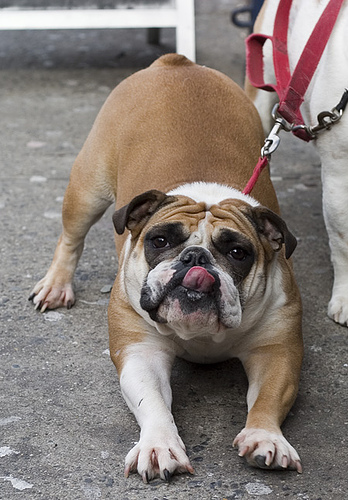

Expected Class: 40
Inference on class: [40] 


Display Image:


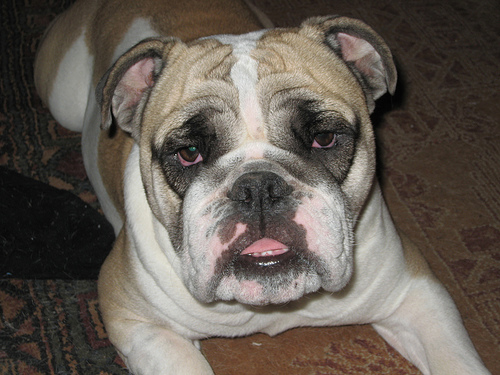

Expected Class: 40
Inference on class: [40] 


Display Image:


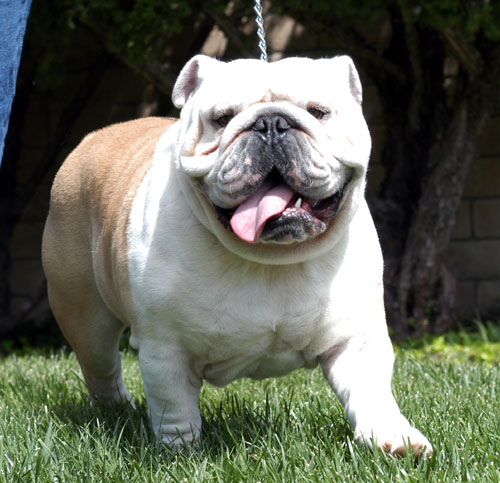

Expected Class: 40
Inference on class: [40] 


Display Image:


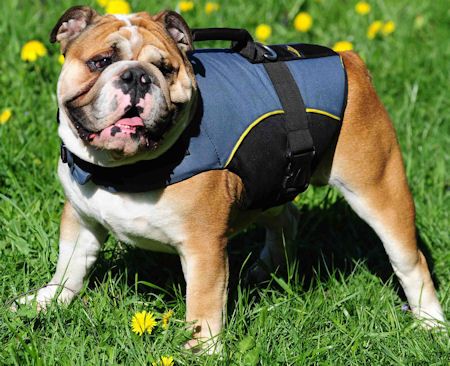

Expected Class: 40
Inference on class: [40] 


Display Image:


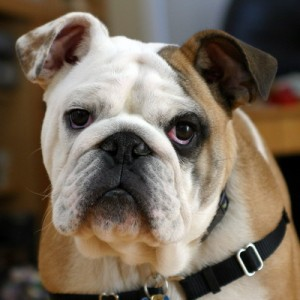

Expected Class: 40
Inference on class: [40] 


Display Image:


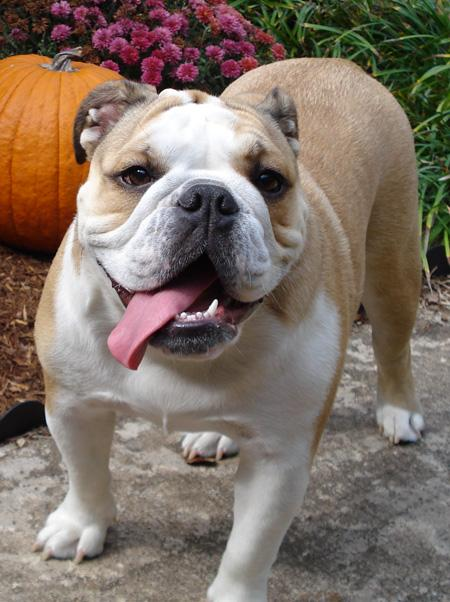

Expected Class: 40
Inference on class: [40] 


Display Image:


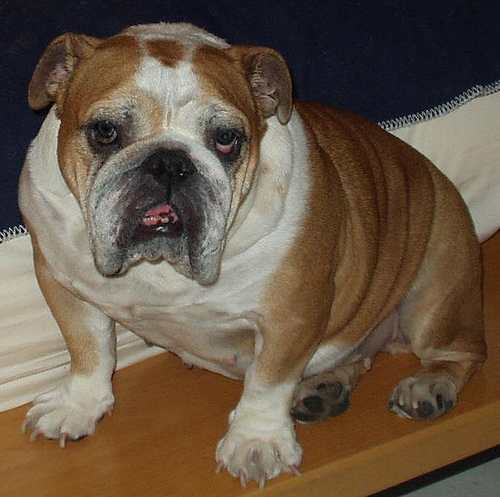

Expected Class: 40
Inference on class: [40] 




In [55]:
from PIL import Image
import io
import os
import numpy as np

test_dir = "./dogImages/test/040.Bulldog/"
test_images = ["Bulldog_02817.jpg", "Bulldog_02828.jpg", "Bulldog_02834.jpg", "Bulldog_02835.jpg", 
                           "Bulldog_02842.jpg", "Bulldog_02845.jpg", "Bulldog_02846.jpg"]
test_images_expected_output = 40

for index in range(len(test_images)):
    
    test_image = test_images[index]
    test_file_path = os.path.join(test_dir, test_image) 
    
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Display Image:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected Class: {test_images_expected_output}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 
        predicted_dog_breed = np.argmax(response, 1) + 1
        print(f"Inference on class: {predicted_dog_breed} \n\n")

In [56]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-09-06-38-48-852
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-09-06-38-48-852
